# Using Astrobject to read an Image and extract sources

Required ingredients:
Image with a wcs solution and a target. 

The examples data "image" and "target" are provided in the "notebooks/data" directory.

**Remark**: If the Image comes from a known instrument (sdss, hst, ptf) you should use the 'Instrument' Class instead of the 'Image' one. 'Intruments' inherit from 'Image' and have additional functionalities. Just change "image" to "instrument"


In [1]:
## plot within the notebook
%matplotlib inline
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')
# - Astrobject Modules
from astrobject.utils.tools import load_pkl
from astrobject import astrotarget
from astrobject import image

## Step one: loading the image and access the data

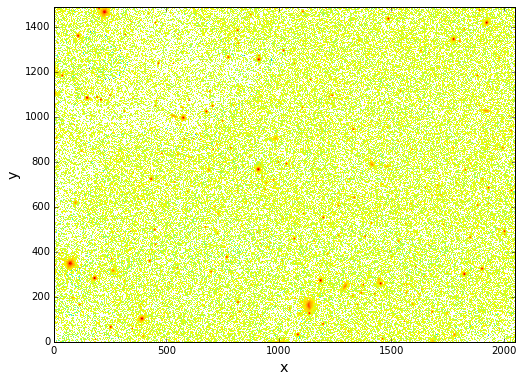

In [2]:
# Load an image object by giving the fits file.
sdssg = image("data/sdss_PTF10qjq_g.fits")
# - Let's see how it looks like
pl = sdssg.show(logscale=True)

#### The show() method returns a dictionnary containing the basic plot information:
* figure: a matplotlib.figure
* ax: the axis where the plot has been made
* imshow/plot/hist/...: the return of the plotting function used, here "imshow"
* prop: information of the properties of the plot (kwargs)
* ... (depending of what you shown)

**_Tip_** use string values for "vmin" and "vmax" imshow argument to use them as percentile values. e.g. vmin="3" means that the vmin value will be percentile(_plotted_value_,3).

In [3]:
print pl

{'ax': <matplotlib.axes._axes.Axes object at 0x1090d2710>, 'imshow': <matplotlib.image.AxesImage object at 0x110168b50>, 'target_plot': None, 'figure': <matplotlib.figure.Figure object at 0x1087f2690>, 'prop': {'origin': 'lower', 'interpolation': 'nearest'}}


### Construction of the image data.

The "data" is a derived parameter. It is based on "rawdata", which is the information recorded in the fits file to which is subtracted a "background". This "background" could you manually set (using set_background()), but as a default it uses the sep library. In the code (see get_sep_background()) sep is ran once to get the background and the detected sources and a second time to get the background once the sources have been masked. 

You can see the "rawdata" and the "background" using the show() method as follow:

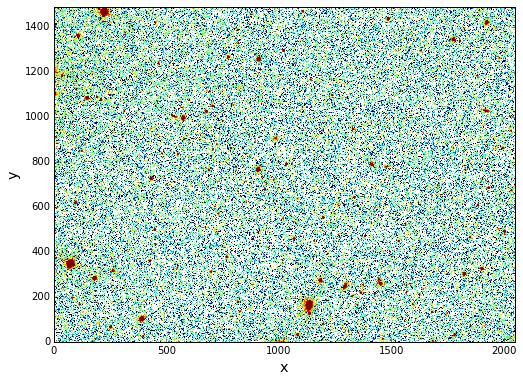

In [7]:
# The Rawdata (shown in logscale, which is the default of the show() method), using vmin and vmax as percentile values
pl = sdssg.show("rawdata",vmax="99",vmin="5")

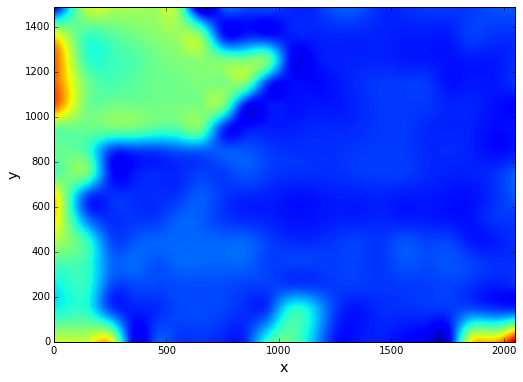

In [8]:
# The background ; see the background mask array using backgroundmask
pl = sdssg.show("background", logscale=False)

#### The show_background() check method:
A methods to visualize the background and the exact data used to estimated the background is implemented under the 'show_background(')method. Except for 'toshow' and 'logscale' (that are here fixed), the argument are these of the 'show()' method used internally.

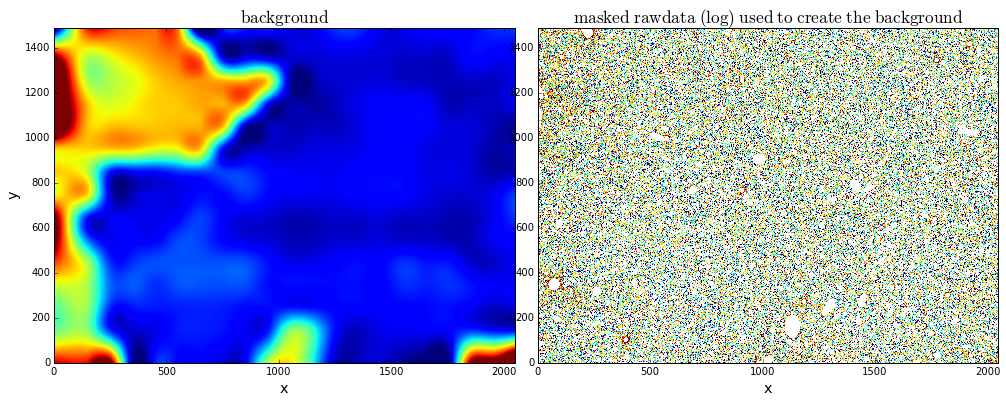

In [11]:
pl = sdssg.show_background(vmin="1",vmax="99")

## Step two: Associating a target to an image

An astrotarget is an object having basic information about a source (whatever that is). 
It has: 
* coordinates (Ra, Dec)
* a name (name)
* a redshift (zcmb)
* a type (type_, like Ia, galaxy...)

Additional information could also be provided:
* the milky way extinction (forced_mwebmv, if this is not provided, the code will fetch it based on Schelgel map)
* a cosmology (cosmo, this must be an astropy.cosmo; Planck13 is currently used as default)

**Remark**: none of the aforementioned information is requested, you can create an empty or partially filled object. 
Several other parameter will however be accessible once the object is set:
* distances (in meter or mpc) if zcmb and a cosmo are provided
* mwebmv (with Ra and Dec)

**Remark**: you can not change the distance, but changing zcmb will do so.

In [12]:
# -------------------------
# - Build the astrotarget
# -------------------------
# Basic data
dicosn = load_pkl("data/PTF10qjq_sninfo.pkl")
print dicosn

{'object': u'PTF10qjq', 'Ra': 256.801708333, 'zcmb': 0.028107, 'Dec': 35.5098277778, 'type': u'Ia', 'MWebmv': 0.0279, 'IUACname': None}


In [13]:
# Create the astrotarget
sn = astrotarget(name=dicosn["object"], zcmb=dicosn["zcmb"],
                 ra=dicosn["Ra"],dec=dicosn["Dec"],
                 type_=dicosn["type"],forced_mwebmv=dicosn["MWebmv"])

In [14]:
print sn.zcmb, sn.ra, sn.dec, sn.distmeter

0.028107 256.801708333 35.5098277778 3.91864629359e+15


### You can now connect the target with the image

In [15]:
# let's add a target
sdssg.set_target(sn)

#### The image have wcs tools that enable to go from Ra,Dec (coords) to pixels indexes
The methodes are pixel_to_coords(x,y) and coords_to_pixels(ra,dec)

In [16]:
# for the 1000,800 point:
print "pixel [1000,800] the corresponding Ra,Dec are", sdssg.pixel_to_coords(1000,800)
# for the target
print "pixel set target the corresponding pixels coords are",sdssg.coords_to_pixel(sn.ra,sn.dec)

pixel [1000,800] the corresponding Ra,Dec are [ 256.82732966   35.4416696 ]
pixel set target the corresponding pixels coords are [ 1129.34872146   164.30083776]


#### Remark that now, when you plot, a white square shows the target location in the image

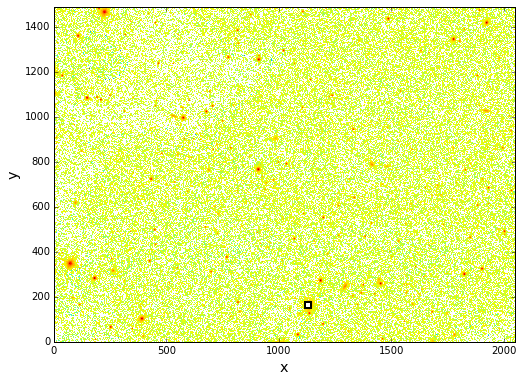

In [17]:
pl = sdssg.show()

#### You can also "zoomon":
* "target" (that will be converted in the target's pixel coords)
* any pixel coords

This will center the image on the requested coordinates with a image window set by "zoompxl" (default 200pxl)

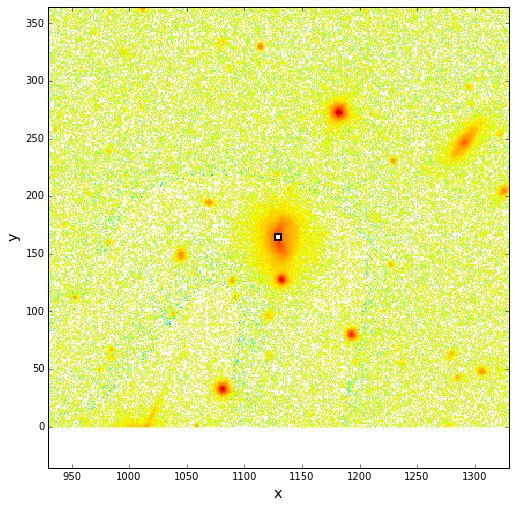

In [18]:
pl = sdssg.show(zoomon="target")

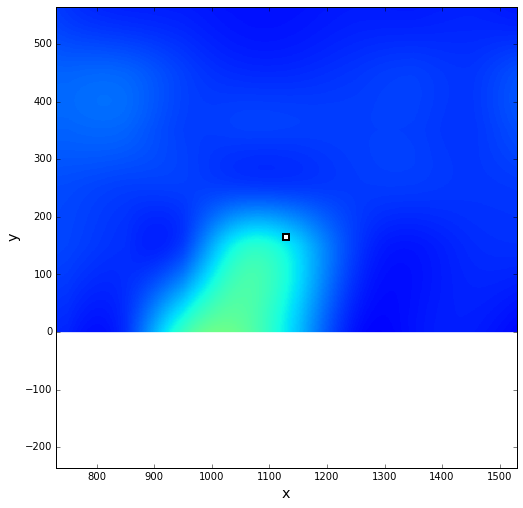

In [19]:
# Which also work with the background, rawdata etc.
pl = sdssg.show(toshow="background", zoomon='target', zoompxl=400, logscale=False)

## Step Three: The source extraction

Thanks to the sep package, (a python/c based API of Sextractor) it is really conviniant to extract sources from the image.

The module sep_extract() runs the extraction on the current image and load the results in the 'sepobjects' object.


In [20]:
sdssg.sep_extract()

visualization of the extracted sources with the show() methods: set show_sepobjects=True.

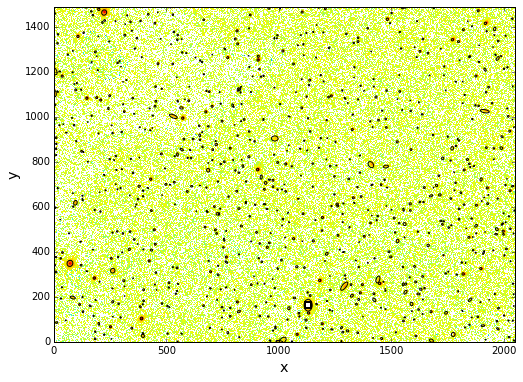

In [21]:
pl = sdssg.show(show_sepobjects=True)

**Remark** several sources have been detected that potentially are image artefacts. Thanks to catalogue matching this issue is solved since sepobjects will know if a source is associated to a catalogue object and which object that is. See the corresponding example

**Information** The image catalogue (if any) and wcs solution (if any) are passed to the sepobjects.

### The SexObjects, play with extracted sources.

#### The sep sources information are recorded in 'sepobjects' (SexObject instance)
**_Tip_** you can test if an 'Image' has a sepobjects loaded using the has_sepobjects() methods (returns True if so)

#### How to use the sepobjects

* The ellipses information are recorded in the astropy table 'data' 

In [22]:
sdssg.sepobjects.data

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
0.0228041633964,8,6,548,551,1,2,549.544941153,1.53658671044,1.05642651986,0.248661412619,0.00121228515037,1.02782702446,0.498657792807,0.00150078465231,0.94659268856,4.02155542374,-0.00922974105924,0.265164732933,0.344002187252,0.0451127737761,0.07296102494,550,2,550,2,0
0.0228041633964,18,15,1056,1060,0,3,1058.05426482,1.18284163162,1.31332146908,0.908669501752,-0.0762049085309,1.15204024315,0.945935606956,-0.180105686188,0.765151560307,1.10589158535,0.128337755799,1.11138021946,1.29729580879,0.117763921618,0.145826473832,1058,1,1059,1,2
0.0228041633964,13,9,1276,1279,0,4,1277.61355749,2.17763391089,0.823551287606,1.36831189092,-0.0686122024539,1.17338001728,0.902797043324,-1.44741392136,1.21934735775,0.733893454075,0.122285149992,0.356967180967,0.410847455263,0.0345862992108,0.058728273958,1278,1,1277,4,1
0.0228041633964,19,14,958,963,2,7,960.803411884,4.80516911559,1.94562516602,2.05048155272,-1.02515282259,1.73912215233,0.985677838326,-0.810946822166,0.697791576385,0.662108302116,0.697731673717,0.489509135485,0.531460106373,0.031577128917,0.0449700839818,961,5,961,6,0
0.0228041633964,15,12,2043,2046,3,7,2044.79223087,5.29772979293,0.842674608591,1.49407630903,-0.488114801266,1.32483124733,0.762609362602,-1.07960581779,1.46368420124,0.825533151627,0.956371426582,0.540553987026,0.662425100803,0.0576232150197,0.0906106382608,2045,5,2045,5,0
0.0228041633964,8,8,1917,1920,8,10,1918.53968753,9.00546371836,0.660955042984,0.466502325473,-0.00149722617842,0.812998533249,0.683001339436,-0.00769908400252,1.51297318935,2.14362764359,0.00971169024706,0.273017376661,0.350766867399,0.0459587648511,0.0695992708206,1919,9,1918,9,0
0.0228041633964,154,138,1669,1686,0,12,1677.8262926,4.71575912682,12.0679182356,8.13389274917,-3.11310940719,3.71259689331,2.53346300125,-0.503643810749,0.0919419452548,0.136410444975,0.0703784376383,8.14661121368,8.48037147522,0.155753225088,0.184312731028,1678,4,1678,3,2
0.0228041633964,6,4,254,256,11,13,255.159246736,12.1902128043,0.447376679224,0.44056300488,0.122489139977,0.752666175365,0.566950917244,0.771495044231,2.41942596436,2.45684432983,-1.34533941746,0.172633245587,0.228540569544,0.0350963026285,0.0599787682295,255,12,255,13,0
0.0228041633964,68,61,179,187,8,17,182.897510566,12.4935008926,2.1972412245,2.53927721999,-0.113520465096,1.60422098637,1.47071182728,-1.27779126167,0.456169784069,0.394724547863,0.0407868884504,18.4056243896,18.6032657623,1.20729029179,1.59217774868,183,12,183,12,0


* you can access each column using sepobjects.data[key] or sepobjects.get(key). Additional key are aviable in throught the get methods that combine dat information: "elongation","ellipticity" and "angsep" (the distance between the sep extracted source and the associated catalogue object; this won't be accessible if no catalogue have been loaded)

In [23]:
sdssg.sepobjects.get("ellipticity")

0.514842691484
0.178904024767
0.230601314129
0.433232543783
0.424372451858
0.159898435848
0.317603533576
0.246743196652
0.083223670693
0.522761977161
0.073291910648


## Additional tools are available when combined with a catalogue. 
### See the Instrument and Catalogue notebook.